In [355]:
import sys
import json
import pickle
import numpy as np
import pandas as pd
import nibabel as nb
from copy import deepcopy
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors
from mne import read_epochs, pick_types
from mne.time_frequency import psd_array_welch
from scipy.interpolate import interp1d
import new_files
import os.path as op
from os import sep
import trimesh
import open3d as o3d
from tools import compute_rel_power, get_crossover, detect_crossing_points
# from ffntr import fooofinator, fooofinator2, fooofinator3
from fooofinator import fooofinator

In [242]:
def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()

def rotation_matrix(theta1, theta2, theta3):
    c1 = np.cos(theta1 * np.pi / 180)
    s1 = np.sin(theta1 * np.pi / 180)
    c2 = np.cos(theta2 * np.pi / 180)
    s2 = np.sin(theta2 * np.pi / 180)
    c3 = np.cos(theta3 * np.pi / 180)
    s3 = np.sin(theta3 * np.pi / 180)
    matrix=np.array([
        [c2*c3, -c2*s3, s2], 
        [c1*s3+c3*s1*s2, c1*c3-s1*s2*s3, -c2*s1], 
        [s1*s3-c1*c3*s2, c3*s1+c1*s2*s3, c1*c2]
    ])
    return matrix


def cb_smooth_csd(csd, layers=11):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind="cubic")
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow

In [3]:
dir_search = new_files.Files()
dataset_path = "/home/common/bonaiuto/multiburst/derivatives/processed"
img_path = "/scratch/poster_visualisations"
all_jsons = dir_search.get_files(dataset_path,"*.json", strings=["info"])

In [15]:
ROIS = {
    "L_4_ROI": "Left Primary Motor Cortex",
    "L_6ma_ROI": "Left Supplementary Motor Area",
    "L_6mp_ROI": "Left Supplementary Motor Area",
    "L_6d_ROI": "Left Pre-Motor Area",
    "L_6v_ROI": "Left Pre-Motor Area",
    "L_6r_ROI": "Left Pre-Motor Area",
    "L_6a_ROI": "Left Pre-Motor Area",
    "L_LIPv_ROI": "Left Intraparietal Area", 
    "L_VIP_ROI": "Left Intraparietal Area", 
    "L_MIP_ROI": "Left Intraparietal Area",
    "L_V1_ROI": "Left Primary Visual Cortex",
    "L_MT_ROI": "Left V5-MT Visual Cortex",
    "R_4_ROI": "Right Primary Motor Cortex",
    "R_6ma_ROI": "Right Supplementary Motor Area",
    "R_6mp_ROI": "Right Supplementary Motor Area",
    "R_6d_ROI": "Right Pre-Motor Area",
    "R_6v_ROI": "Right Pre-Motor Area",
    "R_6r_ROI": "Right Pre-Motor Area",
    "R_6a_ROI": "Right Pre-Motor Area",
    "R_LIPv_ROI": "Right Intraparietal Area", 
    "R_VIP_ROI": "Right Intraparietal Area", 
    "R_MIP_ROI": "Right Intraparietal Area",
    "R_V1_ROI": "Right Primary Visual Cortex",
    "R_MT_ROI": "Right V5-MT Visual Cortex",
}

epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

crop_info = {
    "visual": (-0.2, 0.8),
    "motor": (-0.5, 0.5)
}

flims = [0.1,125] # freq limits for psd

In [280]:
json_file = all_jsons[0]
with open(json_file) as pipeline_file:
    info = json.load(pipeline_file)
cortical_thickness = np.load(info["cortical_thickness_path"])
atlas_labels = np.load(info["atlas_labels_path"])
atlas_colours = np.load(info["atlas_colors_path"])
atlas = pd.read_csv(info["atlas"])

fif_mu = list(zip(info["sensor_epochs_paths"], info["MU_paths"]))

# SUBJ NAMES
epochs, MU = fif_mu[0]
epoch_type = [i for i in epoch_types.keys() if i in epochs][0]
subject = epochs.split(sep)[-3]

# ROI VERTICES
vertex_num = np.arange(atlas_labels.shape[0])
roi_k = np.array(list(ROIS.keys()))
roi_v = np.array(list(ROIS.values()))
ROI_subfields = {i : list(roi_k[roi_v == i]) for i in np.unique(roi_v)}
subfields_vertices = {i: vertex_num[[i == al.decode("utf=8") for al in atlas_labels]] for i in roi_k}
ROI_vertices = {i: np.hstack([subfields_vertices[j] for j in ROI_subfields[i]]) for i in ROI_subfields.keys()}

# ROI COLORMAP
cm = plt.colormaps["jet"]
col_val = np.tile(np.linspace(0,1,num=len(ROI_subfields.keys())//2), 2)
label_colours = cm(col_val)[:,:3]
gray = np.array([0.5, 0.5, 0.5])
brain = nb.load(info["pial_ds_nodeep_inflated"])
vertices, faces = brain.agg_data()
colours = np.repeat(gray.reshape(1,-1), vertices.shape[0], axis=0)
for ix, k in enumerate(ROI_vertices.keys()):
    colours[ROI_vertices[k]] = label_colours[ix]

# ROI BRAIN RENDER
# mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
# mesh = mesh.as_open3d
# mesh.compute_vertex_normals(normalized=True)
# mesh.vertex_colors = o3d.utility.Vector3dVector(colours)

# sphere = o3d.geometry.TriangleMesh.create_sphere(
#     radius=2.0, resolution=10,
#     create_uv_map=True
# )
# sphere.paint_uniform_color(np.array([1.0,1.0,1.0]))
# sphere_pos = vertices[ROI_vertices['Left Intraparietal Area'][100]]
# sphere.translate(sphere_pos)
# custom_draw_geometry([mesh, sphere], save=False)

# ROI LABELS LEGEND

filename = op.join(img_path, "ROI_labels.{}")
if not op.exists(filename.format("svg")):
    bilat_labels = [i[5:] for i in list(ROI_subfields.keys())[:len(ROI_subfields.keys())//2]]
    legend_items = []
    for ix, lab in enumerate(bilat_labels):
        p = Patch(
            facecolor=label_colours[ix],
            label=lab
        )
        legend_items.append(p)
    f, ax = plt.subplots(figsize=(3,2))
    ax.legend(handles=legend_items, loc="center", frameon=False)
    ax.axis("off");
    plt.savefig(filename.format("svg"))


# CSD CALC with FIF MU
fif, MU = fif_mu[1]
core_name = fif.split(sep)[-1].split("_")[-1].split(".")[0]
fif_f, MU_f = fif_mu[0]
epo_type = [i for i in crop_info.keys() if i in fif][0]
fif = read_epochs(fif, verbose=False)
fif = fif.pick_types(meg=True, ref_meg=False, misc=False, verbose=False)
fif = fif.crop(tmin=crop_info[epo_type][0], tmax=crop_info[epo_type][1])
sfreq = fif.info["sfreq"]
fif_times = fif.times
fif = fif.get_data()
fif_all = deepcopy(fif)
fif = np.mean(fif, axis=0) # if no split on conditions

new_mu_path = MU.split(".")[0] + ".npy"
if not op.exists(new_mu_path):
    MU = pd.read_csv(MU, sep="\t", header=None).to_numpy()
    np.save(new_mu_path, MU)
elif op.exists(new_mu_path):
    MU = np.load(new_mu_path)

MU = np.split(MU, info["n_surf"], axis=0)
layer_shape = MU[0].shape[0]
src = []
for i in range(layer_shape):
    vertex_layers = np.array([mx[i] for mx in MU])
    vertex_source = np.dot(fif.T, vertex_layers.T).T
    src.append(vertex_source)
src = np.array(src)



ROI_max_vx = {}
ROI_power = {}
for k in ROI_vertices:
    vx = ROI_vertices[k]
    src_grad = np.array([np.gradient(np.gradient(i, axis=0), axis=0, edge_order=2) for i in src[vx]])
    max_vx_amp = np.nanmax(np.abs(src_grad),axis=(1,2))
    if "Primary Visual" in k:
        minmax = np.percentile(max_vx_amp, 0.005), np.percentile(max_vx_amp, 99.9)
        out_map = max_vx_amp > minmax[1]
        max_vx_amp = max_vx_amp[out_map]
    max_vx = vx[np.argmax(max_vx_amp)]
    ROI_max_vx[k] = [max_vx]
    ROI_max_vx[k].append(src[max_vx])
    ROI_max_vx[k].append(src_grad[np.argmax(max_vx_amp)])
    
    vertex_source = []
    for trial in fif_all:
        layered = np.array([np.dot(trial.T, MU[i][max_vx]) for i in range(info["layers"])])
        vertex_source.append(np.array(layered))
    vertex_source = np.array(vertex_source)
    winsize = int(sfreq)
    overlap = int(winsize/2)
    psd, freqs = psd_array_welch(
        vertex_source, sfreq, fmin=flims[0], 
        fmax=flims[1], n_fft=2000, 
        n_overlap=overlap, n_per_seg=winsize,
        window="hann", verbose=False, n_jobs=1
    )
    mean_psd = np.nanmean(psd,axis=0)
    mean_split = np.vsplit(mean_psd, 11)
    layer_power = []
    layer_periodic = []
    layer_aperiodic = []
    for i in mean_split:
        ff = fooofinator.FOOOFinator()
        PsD = i.flatten()
        ff.fit(freqs, PsD, flims, n_jobs=-1)
        layer_power.append(np.log10(PsD))
        layer_periodic.append(np.log10(PsD) - ff._ap_fit)
        layer_aperiodic.append(ff._ap_fit)
        del ff
    layer_power = np.array(layer_power)
    layer_periodic = np.array(layer_periodic)
    layer_aperiodic = np.array(layer_aperiodic)    
    
    ROI_power[k] = [layer_power, layer_periodic, layer_aperiodic]
    
    relative_total = compute_rel_power(layer_power, freqs)
    relative_periodic = compute_rel_power(layer_periodic, freqs)
    relative_aperiodic = compute_rel_power(layer_aperiodic, freqs)
    smooth_rel_total = cb_smooth_csd(relative_total)
    smooth_rel_per = cb_smooth_csd(relative_periodic)
    smooth_rel_aper = cb_smooth_csd(relative_aperiodic)

    crossover = get_crossover(freqs, smooth_rel_per, smooth_rel_aper)

    f, ax = plt.subplots(2, 3, figsize=(12,7), sharex=True)
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=11))[:,:3]

    for ix in range(info["layers"]):

        ax[0,0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=1.5)
        ax[0,0].set_title("PSD per layer")
        ax[0,0].axvline(7, lw=0.5, c="black")
        ax[0,0].axvline(30, lw=0.5, c="black")
        ax[0,0].axvline(50, lw=0.5, c="black")
        ax[0,1].plot(freqs, layer_periodic[ix], c=cm_l[ix], lw=1.5)
        ax[0,1].set_title("Periodic power")
        ax[0,1].axvline(7, lw=0.5, c="black")
        ax[0,1].axvline(30, lw=0.5, c="black")
        ax[0,1].axvline(50, lw=0.5, c="black")
        ax[0,2].plot(freqs, layer_aperiodic[ix], c=cm_l[ix], lw=1.5)
        ax[0,2].set_title("Aperiodic power")
        ax[0,2].axvline(7, lw=0.5, c="black")
        ax[0,2].axvline(30, lw=0.5, c="black")
        ax[0,2].axvline(50, lw=0.5, c="black")


    ax[1,0].set_title("Relative PSD per layer")
    plot_csd(
        smooth_rel_total, vx,
        info["big_brain_layers_path"], 
        freqs, ax=ax[1,0], cmap="YlGnBu",
        vmin_vmax="norm", cb=False
    )

    ax[1,1].set_title("Relative periodic power")
    plot_csd(
        smooth_rel_per, vx,
        info["big_brain_layers_path"], 
        freqs, ax=ax[1,1], cmap="YlGnBu",
        vmin_vmax="norm", cb=False
    )

    ax[1,2].set_title("Relative aperiodic power")
    layer_deets = plot_csd(
        cb_smooth_csd(relative_aperiodic), vx,
        info["big_brain_layers_path"], 
        freqs, ax=ax[1,2], cmap="YlGnBu",
        vmin_vmax="norm", cb=False, return_details=True
    )

    ax[1,0].set_yticks(np.linspace(0,1, num=info["layers"]))
    ax[1,0].set_yticklabels(np.arange(1,12))
    yl=ax[1,0].get_ylim()
    ax[1,0].plot([7,7],yl,':', lw=0.5, c="black")
    ax[1,0].plot([30,30],yl,':', lw=0.5, c="black")
    ax[1,0].plot([50,50],yl,':', lw=0.5, c="black")
    ax[1,0].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)
    ax[1,1].set_yticks(np.linspace(0,1, num=info["layers"]))
    ax[1,1].set_yticklabels(np.arange(1,12))
    ax[1,1].plot([7,7],yl,':', lw=0.5, c="black")
    ax[1,1].plot([30,30],yl,':', lw=0.5, c="black")
    ax[1,1].plot([50,50],yl,':', lw=0.5, c="black")
    ax[1,1].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)
    ax[1,2].set_yticks(np.linspace(0,1, num=info["layers"]))
    ax[1,2].set_yticklabels(np.arange(1,12));
    ax[1,2].plot([7,7],yl,':', lw=0.5, c="black")
    ax[1,2].plot([30,30],yl,':', lw=0.5, c="black")
    ax[1,2].plot([50,50],yl,':', lw=0.5, c="black")
    ax[1,2].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)

    filename = "_".join(["POWER_CROSSOVER_rel", core_name, k.replace(" ", "_"), ".svg"])
    out_path = op.join(img_path, filename)
    plt.savefig(out_path)
    plt.ioff()

    f, ax = plt.subplots(1, 1, figsize=(4,3.5), sharex=True)

    ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
    g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

    ab_rel_pow = np.mean(smooth_rel_per[:, ab_idx], axis=1)
    g_rel_pow = np.mean(smooth_rel_aper[:, g_idx], axis=1)

    ax.plot(ab_rel_pow,np.linspace(0,1,smooth_rel_total.shape[0]),label='Periodic apha-beta', c="green")
    ax.plot(g_rel_pow,np.linspace(0,1,smooth_rel_total.shape[0]),label='Aperiodic gamma', c="blue")

    ax.set_ylim(1, 0)
    ax.set_yticks(np.linspace(0,1, num=11))
    ax.set_yticklabels(np.arange(1,12));
    for th, lab in layer_deets[0]:
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax.annotate(lab,[0.01, th-0.01],size=15)
    ax.axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

    filename = "_".join(["POWER_CROSSOVER_cro", core_name, k.replace(" ", "_"), ".svg"])
    out_path = op.join(img_path, filename)
    plt.savefig(out_path)
    plt.ioff()

    vx, signal, gradient = ROI_max_vx[k]
    f, ax = plt.subplots(1,3, figsize=(10, 3))

    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=11))[:,:3]

    max_amp = np.abs(signal).max()
    spacing = np.linspace(0, max_amp * 12, num=info["layers"])
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax[0].plot(epoch_types[epo_type][0], vs, lw=1, c=cm_l[ix])
    ax[0].set_yticks(spacing)
    ax[0].set_yticklabels(np.arange(1,12)[::-1])
    ax[0].set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)


    max_amp = np.abs(gradient).max()
    spacing = np.linspace(0, max_amp * 12, num=info["layers"])
    vis_gradient = gradient + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_gradient):
        ax[1].plot(epoch_types[epo_type][0], vs, lw=1, c=cm_l[ix])
    ax[1].set_yticks(spacing)
    ax[1].set_yticklabels(np.arange(1,12)[::-1])
    ax[1].set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)

    CSD_res = cb_smooth_csd(gradient)
    baseline_lim = epoch_types[epo_type][2]
    baseline = np.mean(CSD_res[:, np.where(epoch_types[epo_type][0] < baseline_lim)], axis=2)
    CSD_res = CSD_res - baseline
    CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()

    plot_csd(
        CSD_res, vx,
        info["big_brain_layers_path"], 
        epoch_types[epo_type][0], ax=ax[2]
    )
    ax[2].set_yticks(np.linspace(0,1, num=info["layers"]))
    ax[2].set_yticklabels(np.arange(1,12))

    ax[0].set_title("Source Localized Signal")
    ax[1].set_title("Second spatial\nderivative of the signal")
    ax[2].set_title("Current Source Density\n(cubic interpolation)")
    plt.tight_layout()

    filename = "_".join([core_name, k.replace(" ", "_"), ".svg"])
    out_path = op.join(img_path, filename)
    plt.savefig(out_path)
    plt.ioff()

filename = "_".join(["CSD_vx_sig_grad", core_name + ".pickle"])
out_path = op.join(img_path, filename)
with open(out_path, "wb") as handle:
    pickle.dump(ROI_max_vx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
filename = "_".join(["POWER_freq_psd_ap", core_name + ".pickle"])
out_path = op.join(img_path, filename)
with open(out_path, "wb") as handle:
    pickle.dump(ROI_power, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [278]:
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(colours)

shapes = [mesh]

for i in list(ROI_max_vx.values()):
    sphere = o3d.geometry.TriangleMesh.create_sphere(
        radius=2.0, resolution=2,
        create_uv_map=True
    )
    sphere.paint_uniform_color(np.array([255, 219, 221])/255)
    sphere_pos = vertices[i[0]]
    sphere.translate(sphere_pos)
    shapes.append(sphere)

custom_draw_geometry(shapes, save=False)

In [ ]:
cm = plt.colormaps["rainbow"]

xx = np.linspace(0,1, num=11)[::-1]
yy = np.ones(11)
f, ax = plt.subplots(figsize=(3,3))
for i in xx:
    ax.plot(xx, yy*i, color=cm(i))
    print(np.round(np.array(list(cm(i))[:3])*255, 0))


In [ ]:
cm = plt.colormaps["rainbow"]
cm(np.linspace(0,1, num=11)[::-1])[:,:3]

In [ ]:
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, validate=False)
mesh = mesh.as_open3d
mesh.compute_vertex_normals(normalized=True)
mesh.vertex_colors = o3d.utility.Vector3dVector(atlas_colours[:,:3]/255)
custom_draw_geometry(mesh, save=False)

In [66]:
winsize = int(sfreq)
overlap = int(winsize/2)
psd, freqs = psd_array_welch(
    np.array(vertex_source), sfreq, fmin=flims[0], 
    fmax=flims[1], n_fft=2000, 
    n_overlap=overlap, n_per_seg=winsize,
    window="hann", verbose=False, n_jobs=1
)

In [113]:
layer_power = []
layer_periodic = []
layer_aperiodic = []
for i in mean_split:
    ff = fooofinator.FOOOFinator()
    PsD = i.flatten()
    ff.fit(freqs, PsD, flims, n_jobs=-1)
    layer_power.append(np.log10(PsD))
    layer_periodic.append(np.log10(PsD) - ff._ap_fit)
    layer_aperiodic.append(ff._ap_fit)
    del ff
layer_power = np.array(layer_power)
layer_periodic = np.array(layer_periodic)
layer_aperiodic = np.array(layer_aperiodic)

In [199]:
relative_total = compute_rel_power(layer_power, freqs)
relative_periodic = compute_rel_power(layer_periodic, freqs)
relative_aperiodic = compute_rel_power(layer_aperiodic, freqs)
smooth_rel_total = cb_smooth_csd(relative_total)
smooth_rel_per = cb_smooth_csd(relative_periodic)
smooth_rel_aper = cb_smooth_csd(relative_aperiodic)
crossover = get_crossover(freqs, smooth_rel_per, smooth_rel_aper)

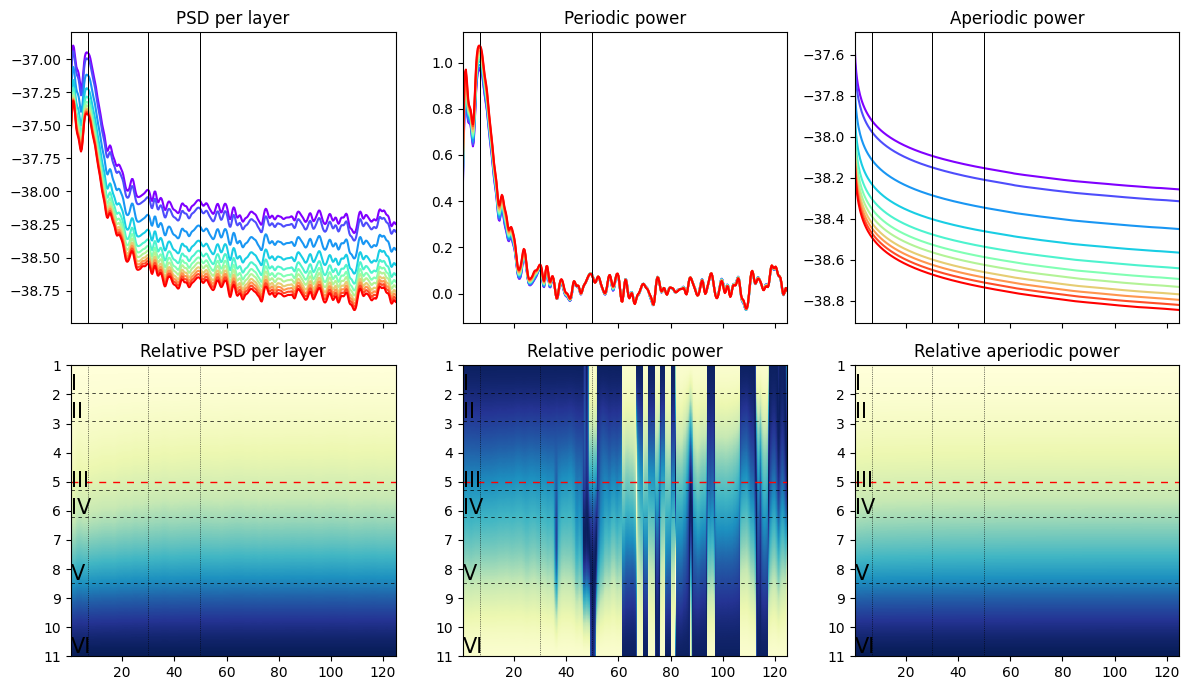

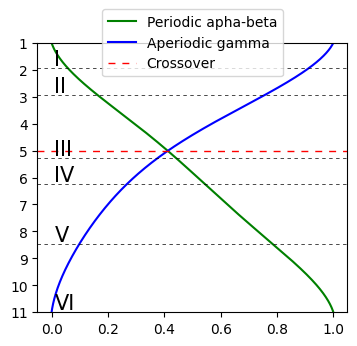

In [253]:
f, ax = plt.subplots(2, 3, figsize=(12,7), sharex=True)
cm = plt.colormaps["rainbow"]
cm_l = cm(np.linspace(0,1, num=11))[:,:3]

for ix in range(info["layers"]):
    
    ax[0,0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=1.5)
    ax[0,0].set_title("PSD per layer")
    ax[0,0].axvline(7, lw=0.5, c="black")
    ax[0,0].axvline(30, lw=0.5, c="black")
    ax[0,0].axvline(50, lw=0.5, c="black")
    ax[0,1].plot(freqs, layer_periodic[ix], c=cm_l[ix], lw=1.5)
    ax[0,1].set_title("Periodic power")
    ax[0,1].axvline(7, lw=0.5, c="black")
    ax[0,1].axvline(30, lw=0.5, c="black")
    ax[0,1].axvline(50, lw=0.5, c="black")
    ax[0,2].plot(freqs, layer_aperiodic[ix], c=cm_l[ix], lw=1.5)
    ax[0,2].set_title("Aperiodic power")
    ax[0,2].axvline(7, lw=0.5, c="black")
    ax[0,2].axvline(30, lw=0.5, c="black")
    ax[0,2].axvline(50, lw=0.5, c="black")

    
ax[1,0].set_title("Relative PSD per layer")
plot_csd(
    smooth_rel_total, vx,
    info["big_brain_layers_path"], 
    freqs, ax=ax[1,0], cmap="YlGnBu",
    vmin_vmax="norm", cb=False
)

ax[1,1].set_title("Relative periodic power")
plot_csd(
    smooth_rel_per, vx,
    info["big_brain_layers_path"], 
    freqs, ax=ax[1,1], cmap="YlGnBu",
    vmin_vmax="norm", cb=False
)

ax[1,2].set_title("Relative aperiodic power")
lp = plot_csd(
    cb_smooth_csd(relative_aperiodic), vx,
    info["big_brain_layers_path"], 
    freqs, ax=ax[1,2], cmap="YlGnBu",
    vmin_vmax="norm", cb=False, return_details=True
)

ax[1,0].set_yticks(np.linspace(0,1, num=info["layers"]))
ax[1,0].set_yticklabels(np.arange(1,12))
yl=ax[1,0].get_ylim()
ax[1,0].plot([7,7],yl,':', lw=0.5, c="black")
ax[1,0].plot([30,30],yl,':', lw=0.5, c="black")
ax[1,0].plot([50,50],yl,':', lw=0.5, c="black")
ax[1,0].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)
ax[1,1].set_yticks(np.linspace(0,1, num=info["layers"]))
ax[1,1].set_yticklabels(np.arange(1,12))
ax[1,1].plot([7,7],yl,':', lw=0.5, c="black")
ax[1,1].plot([30,30],yl,':', lw=0.5, c="black")
ax[1,1].plot([50,50],yl,':', lw=0.5, c="black")
ax[1,1].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)
ax[1,2].set_yticks(np.linspace(0,1, num=info["layers"]))
ax[1,2].set_yticklabels(np.arange(1,12));
ax[1,2].plot([7,7],yl,':', lw=0.5, c="black")
ax[1,2].plot([30,30],yl,':', lw=0.5, c="black")
ax[1,2].plot([50,50],yl,':', lw=0.5, c="black")
ax[1,2].axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1)

filename = "_".join(["POWER_CROSSOVER_rel", core_name, k.replace(" ", "_"), ".svg"])
out_path = op.join(img_path, filename)
plt.savefig(out_path)

f, ax = plt.subplots(1, 1, figsize=(4,3.5), sharex=True)

ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

ab_rel_pow = np.mean(smooth_rel_per[:, ab_idx], axis=1)
g_rel_pow = np.mean(smooth_rel_aper[:, g_idx], axis=1)

ax.plot(ab_rel_pow,np.linspace(0,1,smooth_rel_total.shape[0]),label='Periodic apha-beta', c="green")
ax.plot(g_rel_pow,np.linspace(0,1,smooth_rel_total.shape[0]),label='Aperiodic gamma', c="blue")

ax.set_ylim(1, 0)
ax.set_yticks(np.linspace(0,1, num=11))
ax.set_yticklabels(np.arange(1,12));
for th, lab in lp[0]:
    ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
    ax.annotate(lab,[0.01, th-0.01],size=15)
ax.axhline(crossover/smooth_rel_total.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

filename = "_".join(["POWER_CROSSOVER_cro", core_name, k.replace(" ", "_"), ".svg"])
out_path = op.join(img_path, filename)
plt.savefig(out_path)

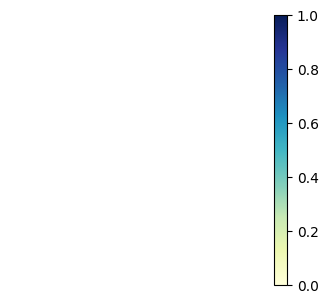

In [250]:
f, ax = plt.subplots(1, 1, figsize=(4,3.5), sharex=True)
plt.colorbar(lp[1], ax=ax)
ax.axis("off")
filename = "colorbar_rel_pow.svg"
out_path = op.join(img_path, filename)
plt.savefig(out_path)


In [293]:
plt.figure().clear()

In [282]:
mean_source = np.mean(vertex_source, axis=0)

In [285]:
mean_source_aug = np.vstack([mean_source[0], mean_source, mean_source[-1]])

In [290]:
mean_source_gradient = np.gradient(np.gradient(mean_source_aug, axis=0), axis=0, edge_order=2)[1:-1]

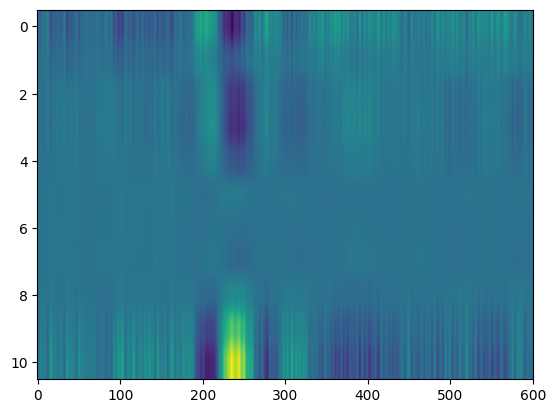

In [296]:
plt.imshow(mean_source_gradient, aspect="auto")
plt.show()

In [342]:
def compute_csd_jank(source_tcs, mean_dist):
    
    nd = 2
    
    source_aug=[]
    for i in range(nd):
        source_aug.append(source_tcs[0])
    source_aug.append(source_tcs)
    for i in range(nd):
        source_aug.append(source_tcs[-1])
    source_aug = np.vstack(source_aug)
    
    # Compute CSD
    spacing = mean_dist*10**-3

    csd=np.zeros(source_tcs.shape)
    for t in range(source_tcs.shape[1]):
        phi=source_aug[:,t]
        for z in range(nd,source_aug.shape[0]-nd):
            csd[z-nd,t]=(phi[z+nd]-2*phi[z]+phi[z-nd])/((nd*spacing)**2)
    
    return csd

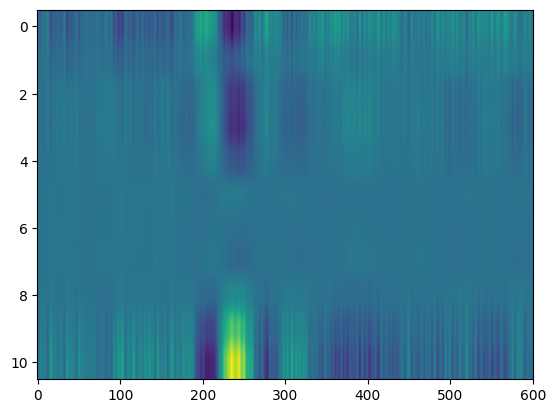

In [350]:
plt.imshow(compute_csd_jank(mean_source,cortical_thickness[max_vx]/10), aspect="auto")
plt.show()

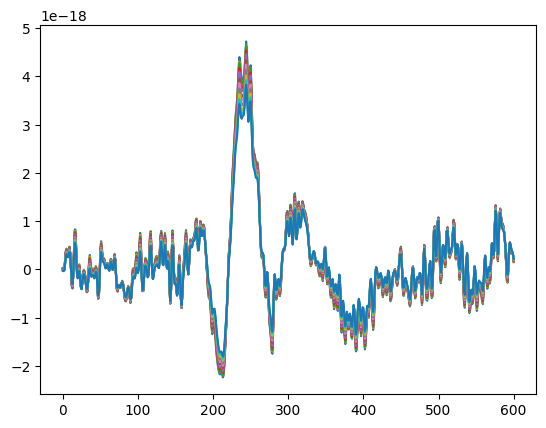

In [327]:
plt.plot(source_tcs.T)
plt.show()

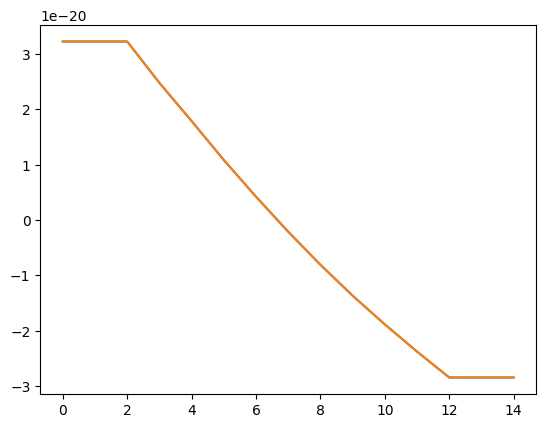

In [310]:
plt.plot(phi)
plt.show()

In [311]:
z=2
(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)

-1.4354948552602958e-14

In [344]:
k

'Right V5-MT Visual Cortex'

In [349]:
max_vx

31250

In [353]:
r = fooofinator(vertex_source, 600.0, [0.1, 120])

IndexError: boolean index did not match indexed array along dimension 1; dimension is 11 but corresponding boolean dimension is 601

In [354]:
vertex_source.shape

(177, 11, 601)